# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import tensorflow as tf
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from tqdm.auto import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout

# Analysing Data Type and Format

In [2]:
df = pd.read_csv("D:/Coding/Python/PROJECTS/Stability/Sound/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#### Using Librosa to analyse random sound sample - SPECTROGRAM

In [3]:
dat1, sampling_rate1 = librosa.load('D:/Coding/Python/PROJECTS/Stability/Sound/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('D:/Coding/Python/PROJECTS/Stability/Sound/fold5/100263-2-0-117.wav')

##### dat1

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

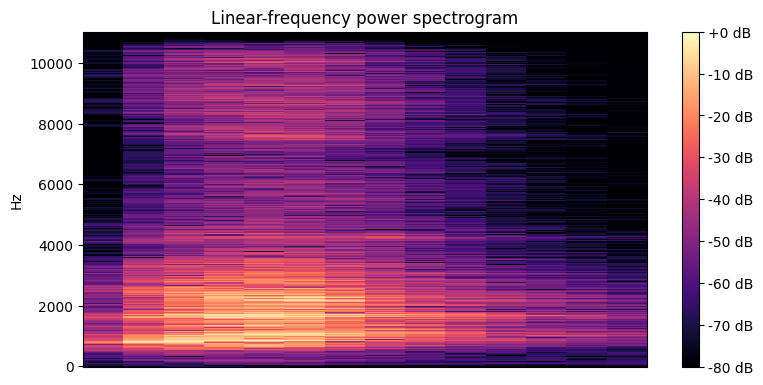

In [4]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

##### dat2

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

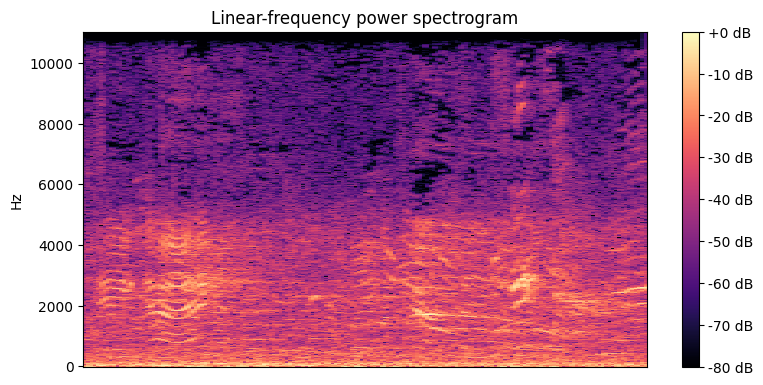

In [5]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

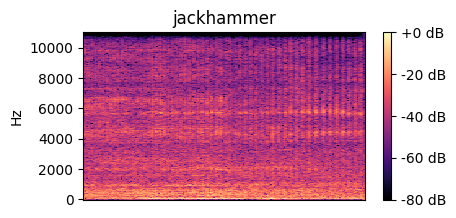

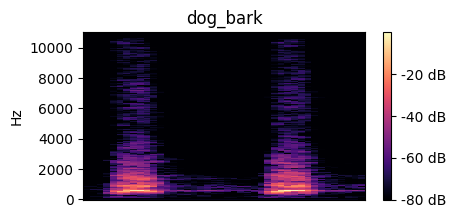

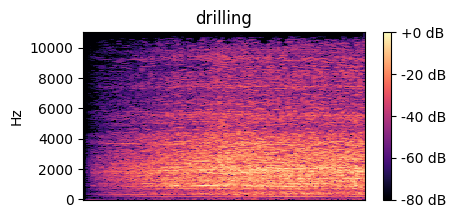

In [6]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = 'D:/Coding/Python/PROJECTS/Stability/Sound/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

# Feature Extraction and Database Building

## • Mel Spectrograms

## • MFCC

In [7]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    feature = librosa.feature.mfcc(y=sample,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = 'D:/Coding/Python/PROJECTS/Stability/Sound'

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(path +'/'+'fold'+ str(row["fold"])+'/', str(row['slice_file_name'])).replace("\\","/")
    final_class_labels = row['class']
    data = features_extract(file_name)
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

d:\Coding\Python\3.9\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
d:\Coding\Python\3.9\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
d:\Coding\Python\3.9\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [8]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

,feature,class
0,"[-211.93698, 62.581203, -122.81315, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86224, -42.658787, 50.690277,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.3139, -44.8471, 24.968985, -9...",car_horn


In [9]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())

In [10]:
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))

#### Train - Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


#### ANN Model

In [12]:
num_labels = y.shape[1]
model = Sequential()

model.add(Dense(128, input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))

model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6528      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

#### Compiling the model

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#### Fitting the model

In [14]:
model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=100,
          validation_data=(x_test, y_test),
         )

Epoch 1/100
219/219 [==============================] - 6s 6ms/step - loss: 9.5606 - accuracy: 0.1343 - val_loss: 2.1949 - val_accuracy: 0.1895
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 2.4466 - accuracy: 0.1865 - val_loss: 2.1987 - val_accuracy: 0.1511
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 2.2025 - accuracy: 0.2220 - val_loss: 2.1749 - val_accuracy: 0.1523
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 2.0895 - accuracy: 0.2518 - val_loss: 1.9954 - val_accuracy: 0.2307
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 1.9790 - accuracy: 0.2880 - val_loss: 1.9001 - val_accuracy: 0.2530
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 1.8678 - accuracy: 0.3357 - val_loss: 1.7112 - val_accuracy: 0.3829
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 1.7774 - accuracy: 0.3727 - val_loss: 1.6027 - val_accuracy: 0.4001

#### Extracting features for prediction

In [15]:
def extract_feature_and_print_prediction(file_name):
    audio_data, sample_rate = librosa.load(file_name) 
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T,axis=0)
    pred_fea = np.array([scaled])
    pred_vector = np.argmax(model.predict(pred_fea),axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The Predicted class is:", pred_class[0], '\n')

In [16]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [17]:
extract_feature_and_print_prediction('D:/Coding/Python/PROJECTS/Stability/Sound/fold2/100652-3-0-2.wav')
ipd.Audio('D:/Coding/Python/PROJECTS/Stability/Sound/fold2/100652-3-0-2.wav')

1/1 [==============================] - 0s 156ms/step
The Predicted class is: dog_bark 



#### Making a h5 file to upload to flask

In [20]:
import joblib
filename = 'sound_classification.h5'
joblib.dump(extract_feature_and_print_prediction, filename)

['sound_classification.h5']